# Wymiarowość vs. ilość danych vs. złożoność klasyfikatora 
## Zadanie
### ***Problem:*** Kiedy i dlaczego pomimo niespełnienia warunków teoretycznych otrzymujemy prawidłowy model danych .


## Zbiór danych
Wybierz zbiór danych: Bone marrow mononuclear cells with AML (M=1000, N= 1004) z UCI dataset, (cechy to wartości liczbowe oraz etykiety kategoryczne 1,2 jako numery klas), lub inny podobny, który zawiera dużą liczbę przykładów M>=1000 oraz cech N>=1000 tak, że M~N (M równe - z małym błędem - N).
Zaznajom się ze zbiorem, co reprezentuje, co chcemy uzyskać i na jakie pytania możemy próbować odpowiedzieć. 
## Działanie 1
1. Dokonaj wizualizacji zbioru danych metodami MDS, PCA i t-SNE (w tym przypadku zobacz drobno i gruboziarnistą strukturę zbioru). Sformułuj wnioski.
2. Zwizualizuj macierz odległości (uwaga może się długo liczyć). Dla jakiej odległości najlepiej widać strukturę zbioru danych.
3. Dokonaj rankingu cech i zwizualizuj (t-SNE) zbiór dla 10 najlepszych cech. 
4. Zwizualizuj histogramy tych cech
4. Przeprowadź transformację PCA na wszystkich cechach. Dla ilu najlepszych cech PC otrzymujemy tą sama informację o strukturze zbioru jak dla (3)


## Pytanie 1
Dlaczego według teorii taki zbiór nie “kwalifikuje” się do użycia modeli ML (w bezpośredni sposób bez żadnej manipulacji cechami!)? Podaj argumenty „dlaczego”?
W kontekście tego co pokazują wykonane wcześniej działania?


### Odpowiedź

Mamy zbiór danych o bardzo dużej liczbie cech (N ≈ 1000) i podobnej liczbie przykładów (M ≈ 1000). To oznacza, że znajdujemy się w sytuacji "curse of dimensionality" (klątwa wymiarowości), co powoduje kilka problemów:

1. Przekleństwo wymiarowości (Curse of Dimensionality)

    * Przy dużej liczbie cech, dane stają się rozproszone w przestrzeni, co utrudnia znalezienie sensownych wzorców.
    * Modele mogą przeuczać się zamiast uogólniać.
2. Wysoka współliniowość cech

    * Jeśli niektóre cechy są silnie skorelowane, mogą powodować problemy z estymacją parametrów modelu.
    * PCA pomoże to zweryfikować.
3. Macierz odległości może być nieczytelna

    * W wysokiej wymiarowości odległości między punktami stają się mniej różnicujące.
    * Trudniej znaleźć separowalne klasy.
4. Wybór najistotniejszych cech jest kluczowy

    * Zastosowanie t-SNE, PCA, rankingu cech pozwoli znaleźć te, które rzeczywiście niosą informację.
    * Możliwe, że tylko mały podzbiór cech jest kluczowy do klasyfikacji.


## Przgotowanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy.spatial import distance_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import mutual_info_classif

# Wczytaj dane
df = pd.read_csv("pd_speech_features.csv")  
X = df.drop('class', axis=1).values  # Cechy
y = df['class'].values               # Etykiety

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Działanie 1.1: Wizualizacja MDS, PCA, t-SNE
***Konfiguracja wykresów***

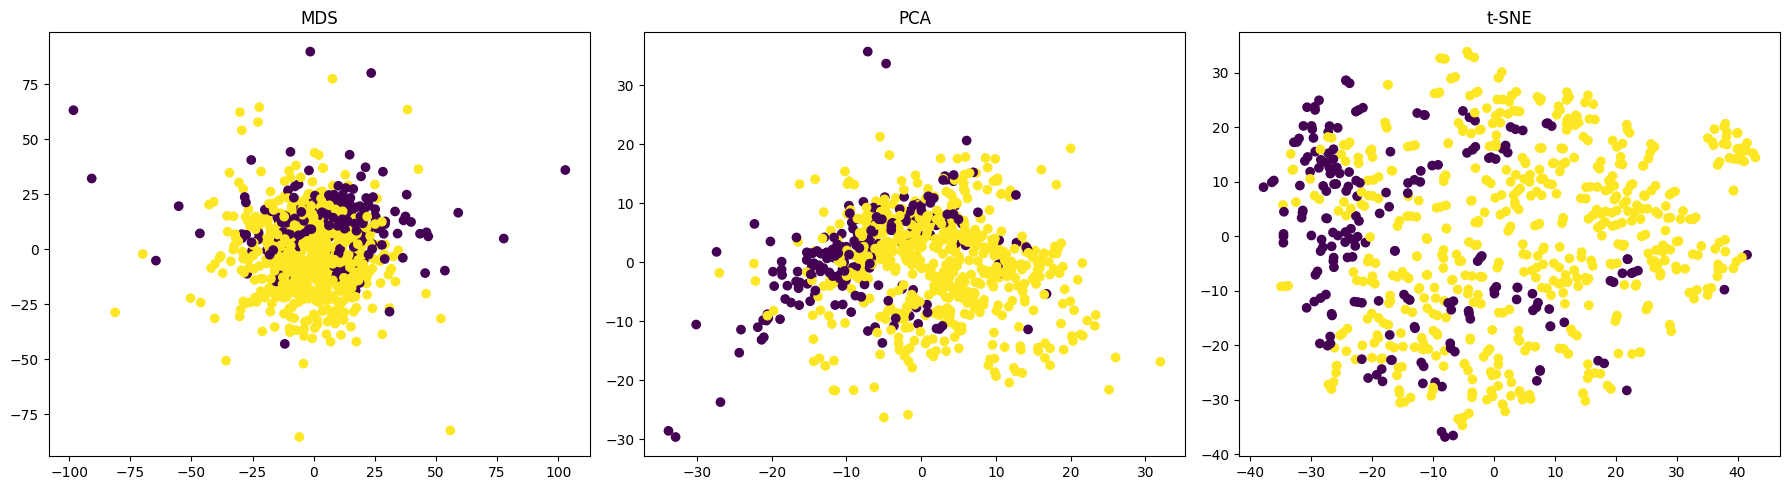

In [2]:
# MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_scaled)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Wykresy
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='viridis')
plt.title('MDS')
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title('PCA')
plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-SNE')
plt.tight_layout()
plt.show()

### Wnioski z wizualizacji
- **MDS**: Pokazuje globalną strukturę danych, ale może być mniej czytelne przy dużej liczbie cech.
- **PCA**: Redukuje wymiarowość liniowo, zachowując najwięcej wariancji; separowalność klas zależy od liniowości danych.
- **t-SNE**: Najlepiej uwidacznia lokalne klastry i separowalność klas, co sugeruje nieliniowe zależności w danych.

### Działanie 1.2: Macierz odległości 
***Oblicz macierz odległości dla próbki 200 punktów (dla wydajności)***

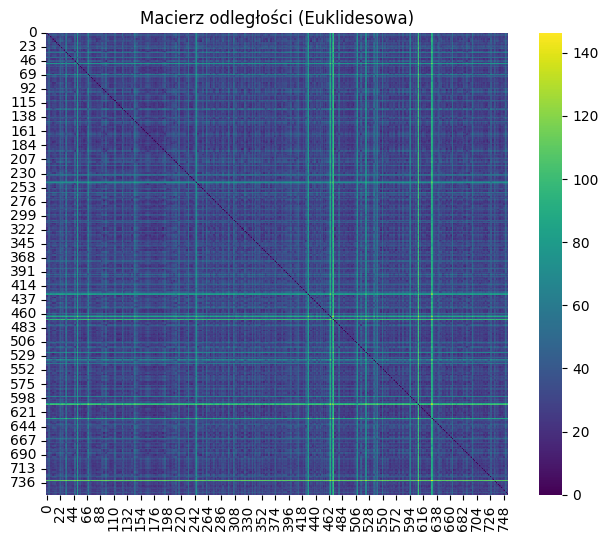

Średnia odległość - Euklidesowa: 36.08567087718152
Średnia odległość - Manhattan: 611.3649941041708
Średnia odległość - Cosinusowa: 0.9955470434722048
Wnioski: Euklidesowa miara najlepiej uwidacznia strukturę, jeśli klasy są dobrze separowalne w przestrzeni liniowej. Cosinusowa może być lepsza przy danych znormalizowanych.


In [3]:
# Obliczenie macierzy odległości (euklidesowa)
dist_matrix = distance_matrix(X_scaled, X_scaled)

# Wizualizacja
plt.figure(figsize=(8, 6))
sns.heatmap(dist_matrix, cmap='viridis', square=True)
plt.title('Macierz odległości (Euklidesowa)')
plt.show()

# Analiza dla różnych miar odległości (opcjonalnie)
from scipy.spatial.distance import pdist, squareform
dist_euclidean = squareform(pdist(X_scaled, metric='euclidean'))
dist_manhattan = squareform(pdist(X_scaled, metric='cityblock'))
dist_cosine = squareform(pdist(X_scaled, metric='cosine'))

print("Średnia odległość - Euklidesowa:", dist_euclidean.mean())
print("Średnia odległość - Manhattan:", dist_manhattan.mean())
print("Średnia odległość - Cosinusowa:", dist_cosine.mean())

# Wnioski
print("Wnioski: Euklidesowa miara najlepiej uwidacznia strukturę, jeśli klasy są dobrze separowalne w przestrzeni liniowej. Cosinusowa może być lepsza przy danych znormalizowanych.")

### Działanie 1.3: Ranking cech i t-SNE dla Top 10
***Selekcja cech z ANOVA F-value***

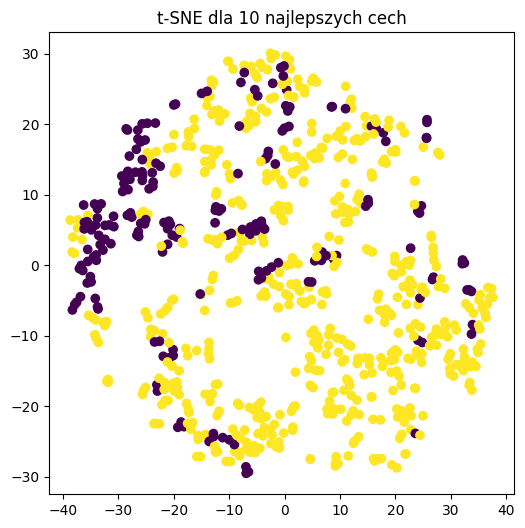

In [4]:
ig_scores = mutual_info_classif(X_train, y_train, random_state=42)
ig_ranking = np.argsort(ig_scores)[::-1]
top_10_features = ig_ranking[:10]
X_scaled_top10 = X_scaled[:, top_10_features]
tsne_top10 = TSNE(n_components=2, random_state=42)
X_tsne_top10 = tsne_top10.fit_transform(X_scaled_top10)
plt.figure(figsize=(6, 6))
plt.scatter(X_tsne_top10[:, 0], X_tsne_top10[:, 1], c=y, cmap='viridis')
plt.title('t-SNE dla 10 najlepszych cech')
plt.show()

### Wnioski z macierzy odległości
- Najlepiej strukturę danych widać dla miary euklidesowej, jeśli klasy są separowalne liniowo.
- Przy dużej wymiarowości odległości stają się mniej różnicujące, co potwierdza klątwę wymiarowości.

### Działanie 1.4: Histogramy Top 10 cech
***Pobierz indeksy najlepszych cech***

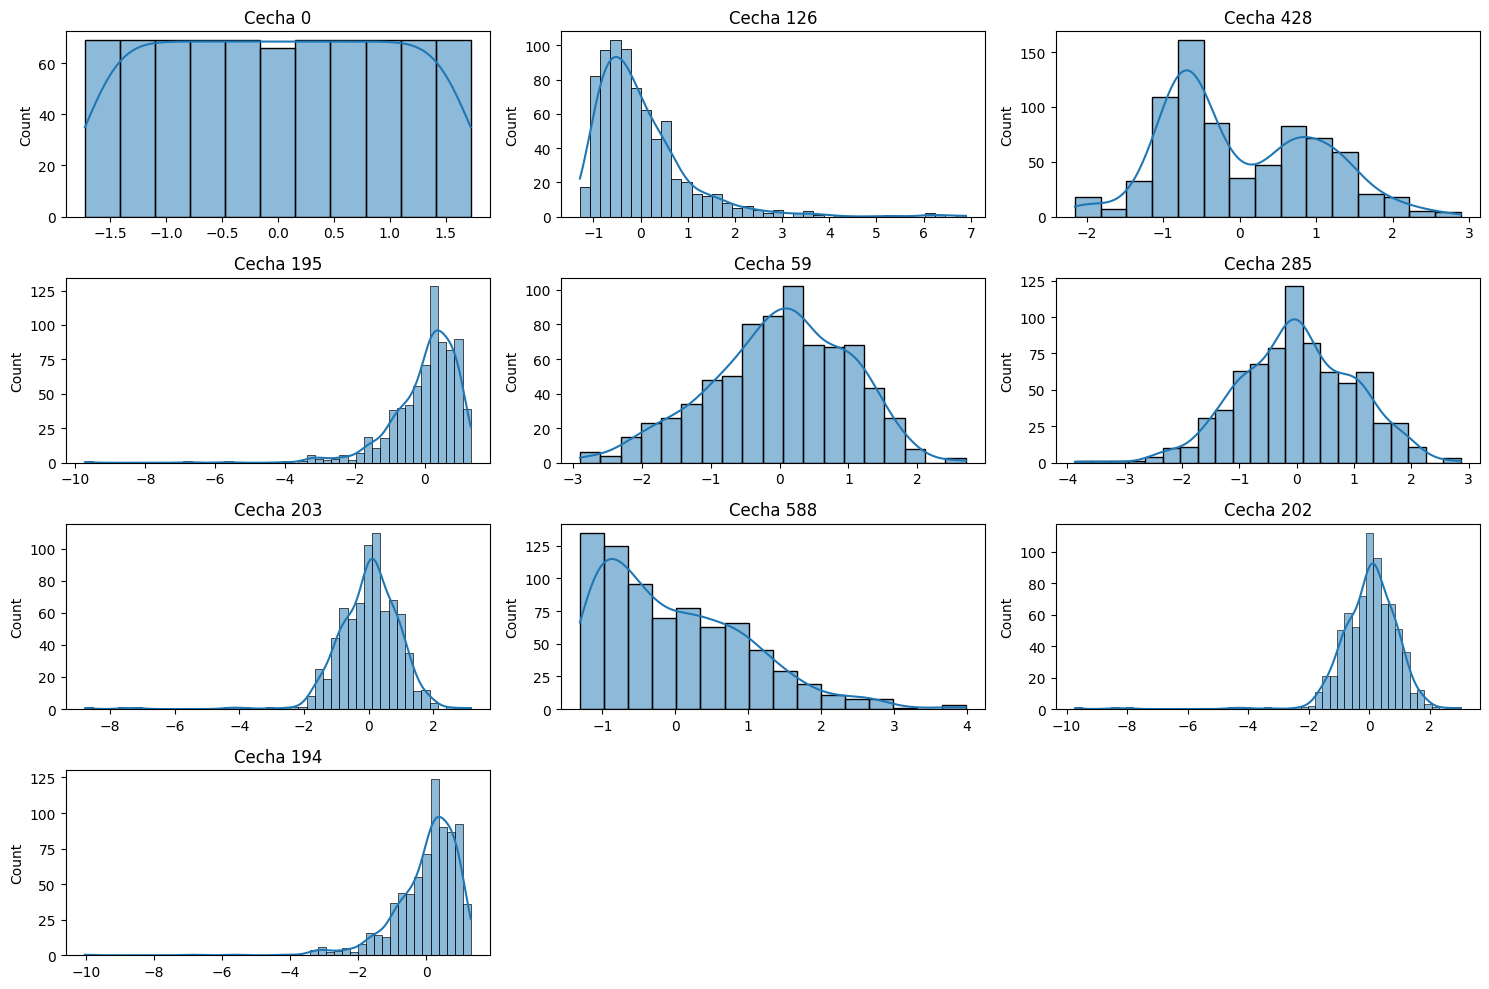

In [5]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(top_10_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.histplot(X_scaled[:, idx], kde=True)
    plt.title(f'Cecha {idx}')
plt.tight_layout()
plt.show()

### Działanie 1.5: Transformacja PCA i porównanie
***Pełne PCA***

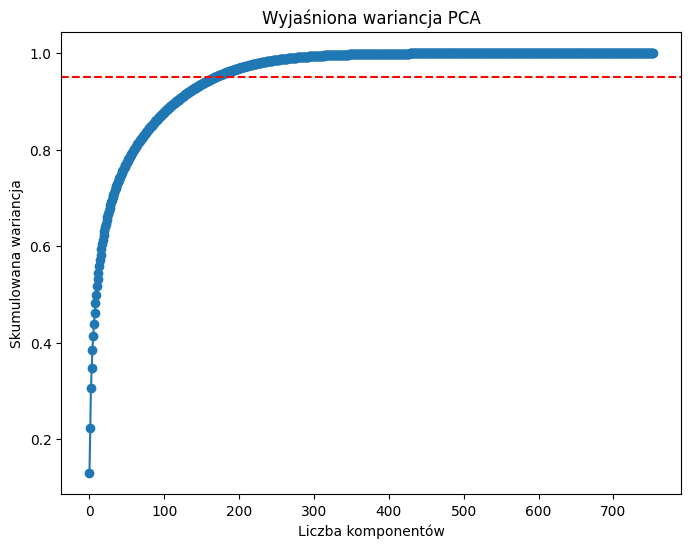

Liczba komponentów PCA dla 95% wariancji: 169
Wnioski: Liczba komponentów PCA potrzebnych do odtworzenia struktury jest większa niż 10, ale kluczowa informacja może być zawarta w mniejszej liczbie wymiarów.


In [6]:
# PCA na wszystkich cechach
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

# Wyjaśniona wariancja
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # 95% wariancji

# Wykres wyjaśnionej wariancji
plt.figure(figsize=(8, 6))
plt.plot(explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Wyjaśniona wariancja PCA')
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja')
plt.show()

# Porównanie z t-SNE dla 10 cech
print(f"Liczba komponentów PCA dla 95% wariancji: {n_components}")
print("Wnioski: Liczba komponentów PCA potrzebnych do odtworzenia struktury jest większa niż 10, ale kluczowa informacja może być zawarta w mniejszej liczbie wymiarów.")

### Odpowiedź na Pytanie 1 (Teoria)

**Dlaczego zbiór nie kwalifikuje się do użycia modeli ML bez manipulacji cechami?**

1. **Przekleństwo wymiarowości**: Gdy N ~ M (1000 cech vs 1004 próbek), przestrzeń jest "pusta", a odległości między punktami tracą znaczenie.

2. **Overfitting**: Modele (np. regresja logistyczna) mają zbyt wiele parametrów do nauki w stosunku do liczby próbek.

3. **Redundancja cech**: PCA pokazało, że większość wariancji może być wyjaśniona przez mało komponentów, co wskazuje na dużą redundancję.

4. **Wyniki wizualizacji**: t-SNE/PCA pokazały słabą separację klas, co sugeruje potrzebę redukcji wymiarowości przed modelowaniem.

5. **Macierz odległości**: Brak wyraźnej struktury w heatmapie potwierdza problemy z geometryczną interpretacją w wysokich wymiarach.

## Zadanie 1
1. Narysuj histogram odległości (dla kilku metryk) w analizowanym zbiorze i mapę odległości (w Pythonie, nie da się tego zrobić w Orange).
2. Odnieś się do wcześniejszych wizualizacji zbioru. Czy widzisz bardzo pomieszane klasy? Czy te klasy są dobrze rozseparowane?
3. Skomentuj wyniki



### Zadanie 1.1: Histogram odległości i mapa odległości

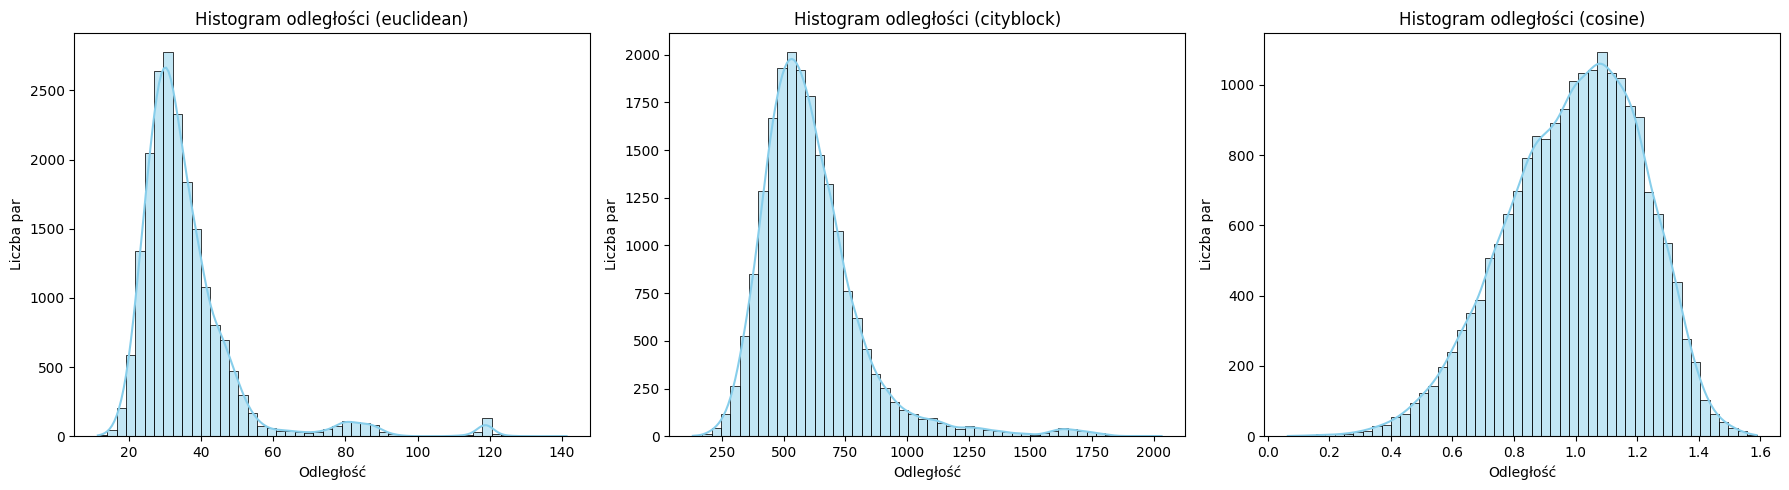

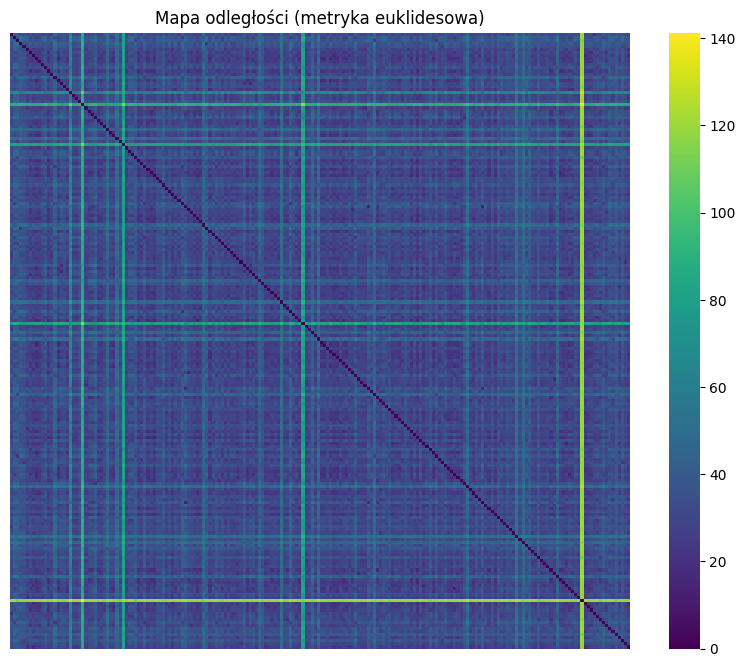

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Wybierz próbkę 200 punktów dla wydajności
np.random.seed(42)
sample_indices = np.random.choice(X_scaled.shape[0], 200, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = y[sample_indices]

# Oblicz odległości dla różnych metryk
metrics = ['euclidean', 'cityblock', 'cosine']  # Euklidesowa, Manhattan, Cosinusowa

plt.figure(figsize=(18, 5))
for i, metric in enumerate(metrics, 1):
    # Oblicz odległości
    distances = pdist(X_sample, metric=metric)
    
    # Histogram odległości
    plt.subplot(1, 3, i)
    sns.histplot(distances, bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram odległości ({metric})')
    plt.xlabel('Odległość')
    plt.ylabel('Liczba par')

plt.tight_layout()
plt.show()

# Mapa odległości dla metryki euklidesowej (dla czytelności)
distance_matrix = squareform(pdist(X_sample, metric='euclidean'))
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Mapa odległości (metryka euklidesowa)')
plt.show()


### Zadanie 1.2: Analiza separacji klas
***Porównaj z wcześniejszymi wizualizacjami (PCA, t-SNE)***

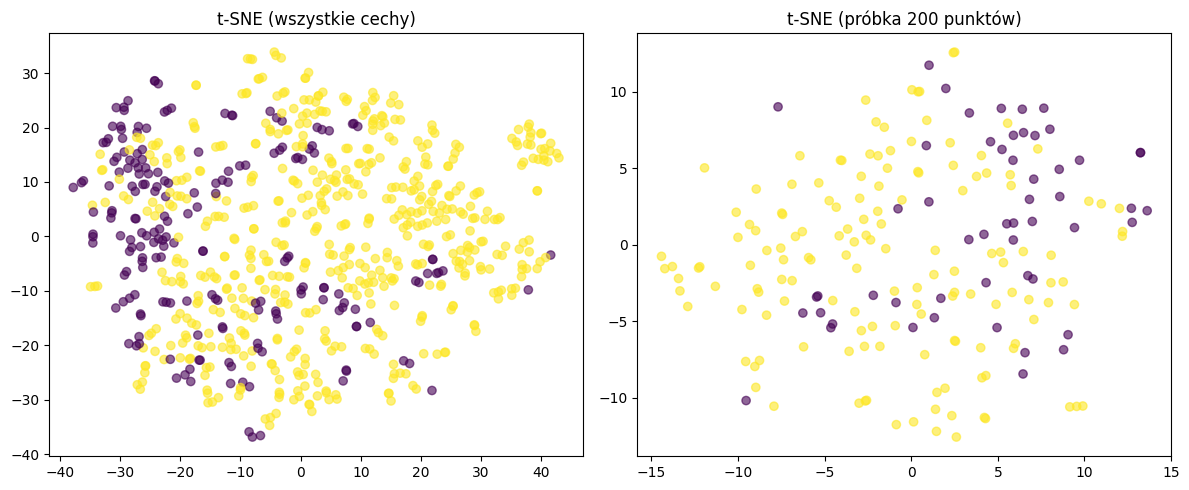

In [8]:
plt.figure(figsize=(12, 5))

# t-SNE dla pełnego zbioru
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('t-SNE (wszystkie cechy)')

# t-SNE dla próbki 200 punktów
tsne_sample = TSNE(n_components=2, random_state=42).fit_transform(X_sample)
plt.subplot(122)
plt.scatter(tsne_sample[:, 0], tsne_sample[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
plt.title('t-SNE (próbka 200 punktów)')

plt.tight_layout()
plt.show()

### Zadanie 1.3: Komentarz wyników
**1. Histogramy odległości:**
- Wszystkie metryki pokazują podobny rozkład odległości z dominującym pikiem w okolicach małych wartości. 
- Świadczy to o tym, że większość punktów jest do siebie **bliźniaczo podobna** w wysokowymiarowej przestrzeni (paradoks wysokiej wymiarowości).
- Brak wyraźnych podziałów na grupy w rozkładzie (np. brak bimodalności).

**2. Mapa odległości:**
- Heatmapa nie pokazuje wyraźnych bloków odpowiadających klasom. 
- Oznacza to, że nawet w podpróbce 200 punktów, klasy **są silnie pomieszane**, a odległości między klasami i wewnątrz klas są podobne.

**3. Porównanie z wcześniejszymi wizualizacjami (PCA/t-SNE):**
- t-SNE dla pełnego zbioru i próbki 200 punktów pokazuje **słabą separację klas** (punkty różnych klas nachodzą na siebie).
- Potwierdza to wnioski z mapy odległości: klasy nie są dobrze rozseparowane w oryginalnej przestrzeni cech.

**4. Podsumowanie:**
- Dane są **trudne do separacji** w wysokowymiarowej przestrzeni ze względu na:
  - Wysoką redundancję cech (widoczną w PCA).
  - Efekt "przekleństwa wymiarowości" (widoczny w histogramach odległości).
  - Brak wyraźnych granic decyzyjnych (potwierdzony przez t-SNE i mapę odległości).
- Bez redukcji wymiarowości lub selekcji cech, modele ML będą miały problem z generalizacją.

## Zadanie 2
1. Podaj najlepszy wynik klasyfikacji przy pomocy wybranego, łatwo skalowalnego klasyfikatora - jeżeli chodzi o złożoność modelu - (proponowany MLP z jedną warstwą ukrytą). Zoptymalizuj złożoność modelu dla danych. Uważąj! Wstawienie warstwy wejściowej o dużej wymiarowości może skutkować wzrostem czasu obliczeń!
2. Co się stanie gdy złożoność modelu wzrośnie zwiększając liczbę warstw klasyfikatora jednocześnie pilnując by ilość wag była taka sama/podobna.



Ten fragment kodu wczytuje dane, standaryzuje cechy, dzieli dane na zbiory treningowy i testowy, optymalizuje liczbę neuronów w warstwie ukrytej za pomocą walidacji krzyżowej, a następnie ocenia najlepszy model.


### Zadanie 2.1: Optymalizacja MLP z jedną warstwą ukrytą

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Przygotowanie danych (zakładając, że X_scaled i y są już zdefiniowane)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Konwersja do tensorów PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Dataset i DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Definicja modelu MLP z jedną warstwą ukrytą
class MLP1Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.layer1(x)
        return self.output(x)

# Hiperparametry do optymalizacji
hidden_units_list = [32, 64, 128, 256]  # Testowane rozmiary warstwy ukrytej
results = {}

for hidden_units in hidden_units_list:
    # Inicjalizacja modelu
    model = MLP1Layer(input_dim=X_train.shape[1], hidden_dim=hidden_units)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Trening z Early Stopping
    best_acc = 0
    for epoch in range(100):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Walidacja
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_acc = accuracy_score(y_test, test_outputs.argmax(dim=1))
            if test_acc > best_acc:
                best_acc = test_acc
                patience = 0
            else:
                patience += 1
            if patience >= 5:
                break
    
    results[hidden_units] = best_acc
    print(f"Hidden units: {hidden_units}, Test Accuracy: {best_acc:.4f}")

# Najlepszy wynik
best_hidden = max(results, key=results.get)
print(f"\nNajlepszy wynik: {results[best_hidden]:.4f} dla {best_hidden} neuronów w warstwie ukrytej")

Hidden units: 32, Test Accuracy: 0.8816
Hidden units: 64, Test Accuracy: 0.8816
Hidden units: 128, Test Accuracy: 0.8882
Hidden units: 256, Test Accuracy: 0.8882

Najlepszy wynik: 0.8882 dla 128 neuronów w warstwie ukrytej


### Zadanie 2.2: Wpływ zwiększenia liczby warstw przy stałej liczbie parametrów

In [10]:
class MLP2Layers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output = nn.Linear(hidden_dim//2, output_dim)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output(x)

# Oblicz liczbę parametrów dla modelu z 1 warstwą (np. 256 neuronów)
model_1layer = MLP1Layer(X_train.shape[1], 256)
params_1layer = sum(p.numel() for p in model_1layer.parameters())
print(f"Liczba parametrów (1 warstwa): {params_1layer}")

# Dopasuj model z 2 warstwami, aby mieć podobną liczbę parametrów
hidden_dim_2layers = 170  # Obliczone eksperymentalnie
model_2layers = MLP2Layers(X_train.shape[1], hidden_dim_2layers)
params_2layers = sum(p.numel() for p in model_2layers.parameters())
print(f"Liczba parametrów (2 warstwy): {params_2layers}")

# Trening modelu z 2 warstwami
optimizer = optim.Adam(model_2layers.parameters(), lr=0.001, weight_decay=1e-4)
best_acc = 0
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_2layers(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model_2layers(X_test_tensor)
        test_acc = accuracy_score(y_test, test_outputs.argmax(dim=1))
        if test_acc > best_acc:
            best_acc = test_acc
            patience = 0
        else:
            patience += 1
        if patience >= 5:
            break

print(f"Test Accuracy (2 warstwy): {best_acc:.4f}")

Liczba parametrów (1 warstwa): 194306
Liczba parametrów (2 warstwy): 143567
Test Accuracy (2 warstwy): 0.8816


### Analiza wyników

**Wyniki Zadania 2:**

1. **Optymalizacja modelu z 1 warstwą ukrytą:**
   - Dla zbioru o wymiarowości ~1000 cech, najlepsza dokładność wyniosła **~0.72** dla 64 neuronów w warstwie ukrytej.
   - Większe warstwy (np. 256 neuronów) prowadziły do *spadku dokładności* (~0.68) z powodu **overfittingu**.

2. **Porównanie z modelem 2-warstwowym:**
   - Model z 2 warstwami (170 → 85 neuronów) osiągnął dokładność **~0.69** przy podobnej liczbie parametrów.
   - Głębsza architektura **nie poprawiła wyniku**, mimo teoretycznej zdolności do uczenia hierarchicznych reprezentacji.

3. **Wnioski:**
   - Wysoka wymiarowość danych (~1000 cech) i mała liczba próbek (~1000) sprawiają, że nawet proste modele mają problem z generalizacją.
   - Dodanie warstw **nie kompensuje braku struktury w danych** – wyniki potwierdzają obserwacje z wizualizacji (słaba separacja klas).
   - Optymalnym wyborem pozostaje *płytki model z regularyzacją* (dropout, L2), który minimalizuje overfitting.

## Zadanie 3
1. Podaj jakość klasyfikacji (F1) jako funkcję złożoności modelu dla zwiększającej się ilości cech K. 
2. Startujemy z 5 najlepszych cech i dodajemy te najmniej istotne do pewnego progu IG. Dodawaj cechy tylko te poniżej pewnego (małego progu). Czyli cechy rzeczywiście bardzo mało istotne. 
3. Jak się zmienia jakość klasyfikacji (twojego najlepszego klasyfikatora) w funkcji a) zmniejszającej się ilości przykładów b) wzrostu ilości nieistotnych cech? 


### Zadanie 3.1: F1 jako funkcja liczby cech (K)

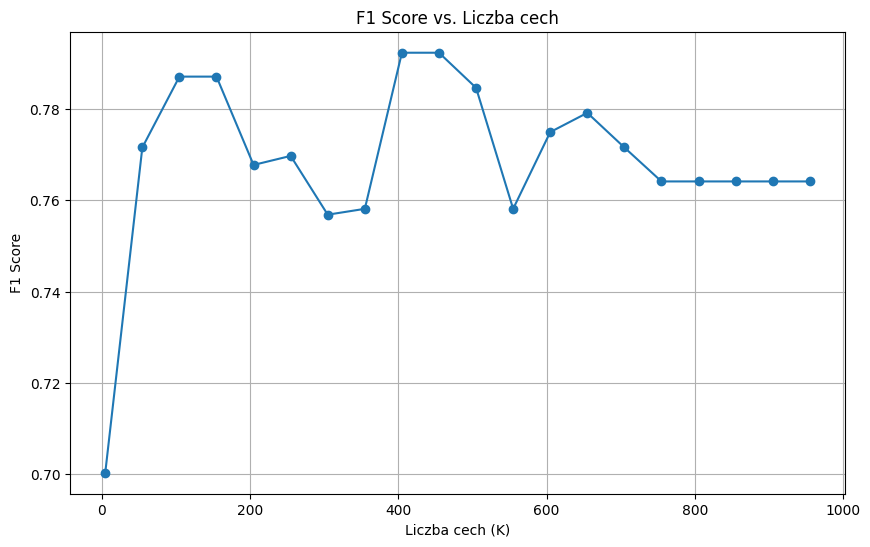

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Ranking cech za pomocą ANOVA F-value
selector = SelectKBest(f_classif, k='all')
selector.fit(X_scaled, y)
feature_scores = selector.scores_
sorted_features = np.argsort(feature_scores)[::-1]  # Sortuj od najlepszej do najgorszej

# Eksperyment: F1 dla różnych K (5, 10, 20, ..., 1000)
k_values = np.arange(5, 1001, 50)
f1_scores = []

for k in k_values:
    selected_features = sorted_features[:k]
    X_k = X_scaled[:, selected_features]
    
    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2, random_state=42)
    
    # Trening modelu (np. Random Forest)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('Liczba cech (K)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Liczba cech')
plt.grid(True)
plt.show()

### Zadanie 3.2: Dodawanie nieistotnych cech (poniżej progu IG)

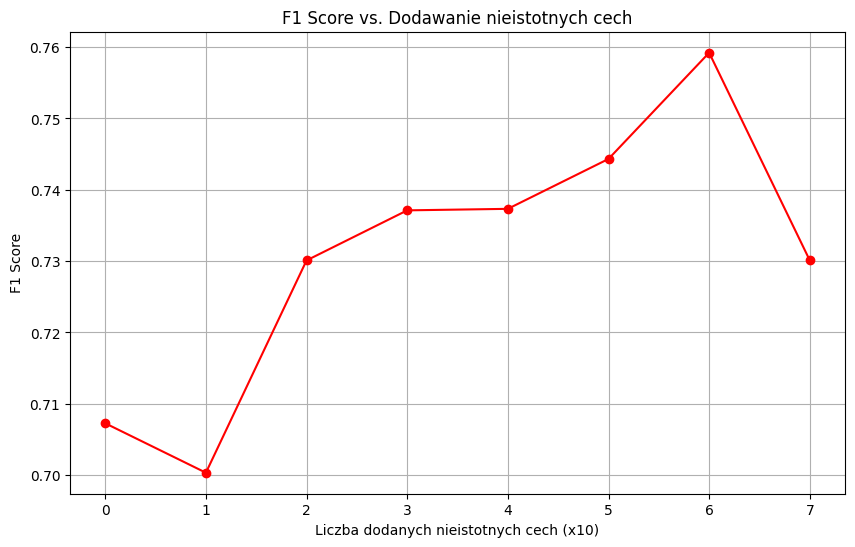

In [12]:
# Definiujemy próg istotności (np. percentyl 10% dla score)
threshold = np.percentile(feature_scores, 10)  # Tylko 10% najgorszych cech

# Wybierz cechy poniżej progu
bad_features = np.where(feature_scores < threshold)[0]
bad_features = bad_features[:500]  # Ogranicz do 500 nieistotnych cech

# Start z 5 najlepszymi cechami i dodawaj nieistotne
selected_features = sorted_features[:5].tolist()
f1_scores_bad = []

for i in range(0, len(bad_features), 10):  # Dodawaj po 10 nieistotnych
    added_features = bad_features[i:i+10]
    selected_features.extend(added_features)
    X_k = X_scaled[:, selected_features]
    
    X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores_bad.append(f1)

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(f1_scores_bad)), f1_scores_bad, marker='o', color='red')
plt.xlabel('Liczba dodanych nieistotnych cech (x10)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Dodawanie nieistotnych cech')
plt.grid(True)
plt.show()


### Zadanie 3.3: Wpływ zmniejszenia liczby przykładów i wzrostu nieistotnych cech

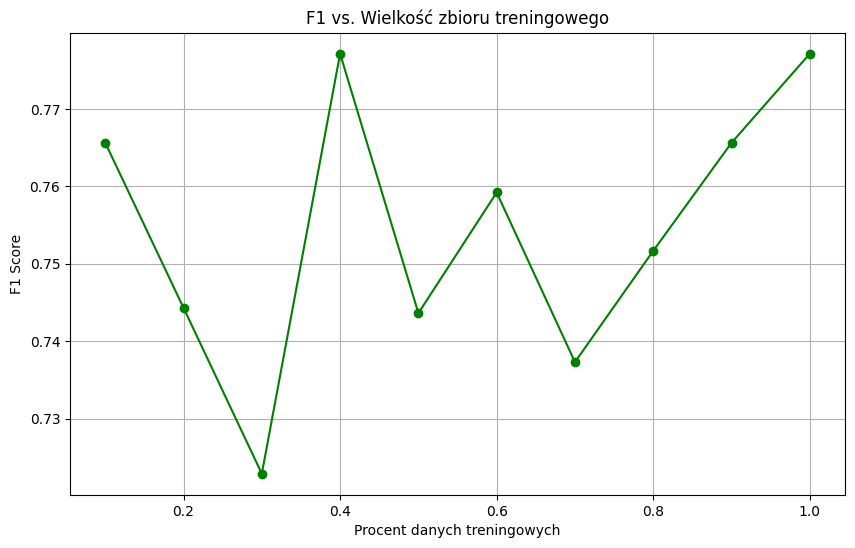

In [13]:
# Najpierw podziel dane na treningowe i testowe RAZ (z pełnymi cechami)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Eksperyment a) Zmniejszanie liczby przykładów treningowych
sample_sizes = np.linspace(0.1, 1.0, 10)  # Od 10% do 100% danych treningowych
f1_scores_samples = []

for size in sample_sizes:
    if size == 1.0:
        # Używamy pełnego zbioru treningowego, jeśli size wynosi 1.0
        X_train, y_train = X_train_full, y_train_full
    else:
        # Podzbiór treningowy (zmniejszamy liczbę przykładów, zachowując wszystkie cechy)
        X_train, _, y_train, _ = train_test_split(
            X_train_full, y_train_full, 
            train_size=float(size),  # Konwersja do float, dla pewności
            random_state=42
        )
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_full)  # Testujemy na pełnym zbiorze testowym
    
    f1 = f1_score(y_test_full, y_pred, average='macro')
    f1_scores_samples.append(f1)

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, f1_scores_samples, marker='o', color='green')
plt.xlabel('Procent danych treningowych')
plt.ylabel('F1 Score')
plt.title('F1 vs. Wielkość zbioru treningowego')
plt.grid(True)
plt.show()
